**import Libraries**

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from tensorflow.keras.applications import VGG16, InceptionResNetV2
from keras import regularizers
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax

*Define constants*

**Import dataset**

Path to dataset folders( train and test)

In [2]:
train_dir = "/kaggle/input/fer2013/train"
test_dir = "/kaggle/input/fer2013/test"

**Data augmentation**

The ImageDataGenerator is a convenient tool for image preprocessing and data augmentation. It helps in preparing image data for deep learning models by automatically applying transformations like scaling, flipping, or rotating images.

In [3]:
img_size = 48

In [4]:
train_datagen = ImageDataGenerator(#rotation_range = 180,
                                         width_shift_range = 0.1,
                                         height_shift_range = 0.1,
                                         horizontal_flip = True,
                                         rescale = 1./255,
                                         #zoom_range = 0.2,
                                         validation_split = 0.2
                                        )
validation_datagen = ImageDataGenerator(rescale = 1./255,
                                         validation_split = 0.2)

In [5]:
train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (img_size,img_size),
                                                    batch_size = 64,
                                                    color_mode = "grayscale",
                                                    class_mode = "categorical",
                                                    subset = "training"
                                                   )


Found 22968 images belonging to 7 classes.


In [6]:

validation_generator = validation_datagen.flow_from_directory( directory = test_dir,
                                                              target_size = (img_size,img_size),
                                                              batch_size = 64,
                                                              color_mode = "grayscale",
                                                              class_mode = "categorical",
                                                              subset = "validation"
                                                             )

Found 1432 images belonging to 7 classes.


**Model VGG16**

VGG16 is a pre-trained deep learning model designed for image recognition tasks. For facial emotion recognition, it extracts key features like eyes, mouth, and expressions from images and helps classify emotions such as happy, sad, or angry.

In [7]:
model = tf.keras.Sequential([

        # input layer
        tf.keras.layers.Conv2D(32,(3,3),activation = 'relu',input_shape=(48,48,1)),
        tf.keras.layers.Conv2D(64,(3,3), padding='same', activation='relu' ),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.25),

        # 1st hidden dense layer
        tf.keras.layers.Conv2D(128,(5,5), padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.25),
    
        # 2nd hidden dense layer
        tf.keras.layers.Conv2D(512,(3,3), padding='same', activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.25),
    
        # 3rd hidden dense layer
        tf.keras.layers.Conv2D(512,(3,3), padding='same', activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.25),
    
        # Flatten layer
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.25),
    
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.25),
        # output layer
        tf.keras.layers.Dense(7, activation='softmax')
    ])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
from tensorflow.keras.optimizers import Adam

# Use 'learning_rate' instead of 'lr'
optimiser = Adam(learning_rate=0.0001)

# Compile the model with the corrected optimizer
model.compile(
    optimizer=optimiser,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display the model summary
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 46, 46, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 46, 46, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 46, 46, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 23, 23, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 23, 23, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 23, 23, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 23, 23, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 11, 11, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 11, 11, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 11, 11, 512)         │         590,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 11, 11, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 5, 5, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 5, 5, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 5, 5, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 5, 5, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,841,543 (14.65 MB)

 Trainable params: 3,837,575 (14.64 MB)

 Non-trainable params: 3,968 (15.50 KB)

In [9]:
epochs = 100
batch_size = 64

In [10]:
history = model.fit(x = train_generator,
                    epochs = epochs,
                    validation_data = validation_generator)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


359/359 ━━━━━━━━━━━━━━━━━━━━ 141s 348ms/step - accuracy: 0.1746 - loss: 9.6068 - val_accuracy: 0.1774 - val_loss: 8.7280
Epoch 2/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 34s 93ms/step - accuracy: 0.2058 - loss: 8.5822 - val_accuracy: 0.2563 - val_loss: 7.6641
Epoch 3/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 33s 91ms/step - accuracy: 0.2376 - loss: 7.6557 - val_accuracy: 0.2968 - val_loss: 6.6989
Epoch 4/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 33s 90ms/step - accuracy: 0.2551 - loss: 6.7281 - val_accuracy: 0.3394 - val_loss: 5.8501
Epoch 5/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 33s 90ms/step - accuracy: 0.2813 - loss: 5.8497 - val_accuracy: 0.3541 - val_loss: 5.0349
Epoch 6/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 34s 92ms/step - accuracy: 0.3194 - loss: 5.0571 - val_accuracy: 0.3911 - val_loss: 4.3545
Epoch 7/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 32s 87ms/step - accuracy: 0.3497 - loss: 4.3964 - val_accuracy: 0.3946 - val_loss: 3.8925
Epoch 8/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 34s 93ms/step - accuracy: 0.3795 - loss: 3.8215 - va

**Evaluate the Model** 

Evaluate the model performance using accuracy and F1 score. Additionally,plot training and validation accuracy.

In [19]:
train_loss, train_acc = model.evaluate(train_generator)
test_loss, test_acc   = model.evaluate(validation_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_acc*100, test_acc*100))

359/359 ━━━━━━━━━━━━━━━━━━━━ 50s 138ms/step - accuracy: 0.7566 - loss: 1.1333
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.6495 - loss: 1.4088
final train accuracy = 75.80 , validation accuracy = 65.85


In [20]:
# F1 Score calculation
from sklearn.metrics import classification_report

# Get predictions
y_pred = model.predict(validation_generator, steps=validation_generator.samples // batch_size + 1)
y_pred_classes = np.argmax(y_pred, axis=1)


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step


In [17]:
# Get true labels
y_true = validation_generator.classes

# Report F1 Score and other metrics
print(classification_report(y_true, y_pred_classes, target_names=validation_generator.class_indices.keys()))

              precision    recall  f1-score   support

       angry       0.11      0.17      0.14       191
     disgust       0.00      0.00      0.00        22
        fear       0.15      0.16      0.15       204
       happy       0.22      0.20      0.21       354
     neutral       0.16      0.19      0.17       246
         sad       0.14      0.09      0.11       249
    surprise       0.11      0.10      0.11       166

    accuracy                           0.15      1432
   macro avg       0.13      0.13      0.13      1432
weighted avg       0.16      0.15      0.15      1432



**Plot Training and Validation Accuracy**

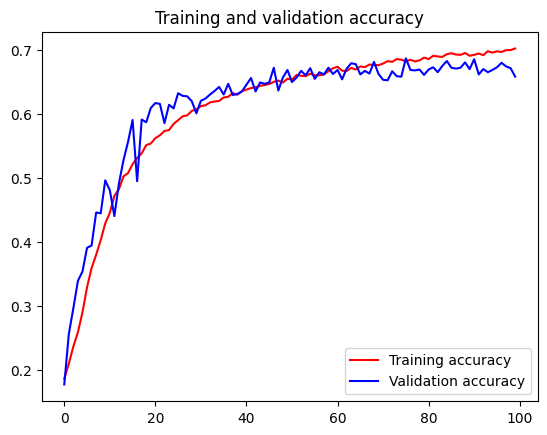

<Figure size 640x480 with 0 Axes>

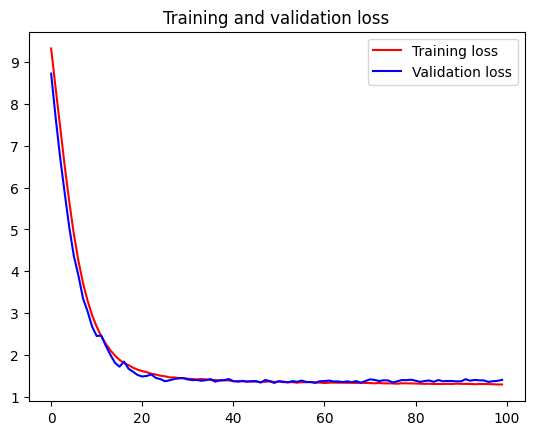

In [18]:
import matplotlib.pyplot as plt
accuracy = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()



plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.show()

**Testing the model**

Giving a random image from dataset.


(48, 48)


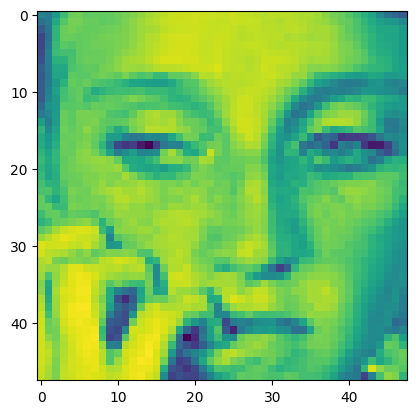

In [21]:
img = image.load_img("/kaggle/input/fer2013/test/fear/PrivateTest_11014592.jpg",target_size = (48,48),color_mode = "grayscale")
img = np.array(img)
plt.imshow(img)
print(img.shape)

In [23]:
label_dict = {0:'Angry',1:'Disgust',2:'Fear',3:'Happy',4:'Neutral',5:'Sad',6:'Surprise'}

In [26]:
img = np.expand_dims(img,axis = 0) #makes image shape (1,48,48)
img = img.reshape(1,48,48,1)
result = model.predict(img)
result = list(result[0])
print(result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[8.2208734e-33, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]


In [28]:
img_index = result.index(max(result))
print(label_dict[img_index])
plt.show()

Fear
